In [111]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import numpy as np
%matplotlib inline

In [112]:
# read in all the words
words = open('../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [113]:
len(words)

32033

In [114]:
# build vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [115]:
# build dataset
#size of the context
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch] # get integer value of char
            X.append(context) # add current context to X, the set of all contexts
            Y.append(ix) # add char after context to Y, the output based on corresponding context
            context = context[1:] + [ix] # drop the first thing in the context and add the last to the end
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

#make training, validation, and test training sets
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [116]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**.5) #5/3 is gain for tanh, divided by the sqr of the fann(number of inputs)
#b1 = torch.randn(n_hidden,                        generator=g) * .01 # have initialization have a little entropy, but dont make it too large
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * .01 # so that w2 is small numbers, reducing size of logits at init and reducing loss at init
b2 = torch.randn(vocab_size,                      generator=g) * 0 #so that b2 is 0 at initialization, making loss at init better

# batch normalization gain
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))

bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


tensor(0.0030) tensor(1.0009)
tensor(0.0042) tensor(0.9436)


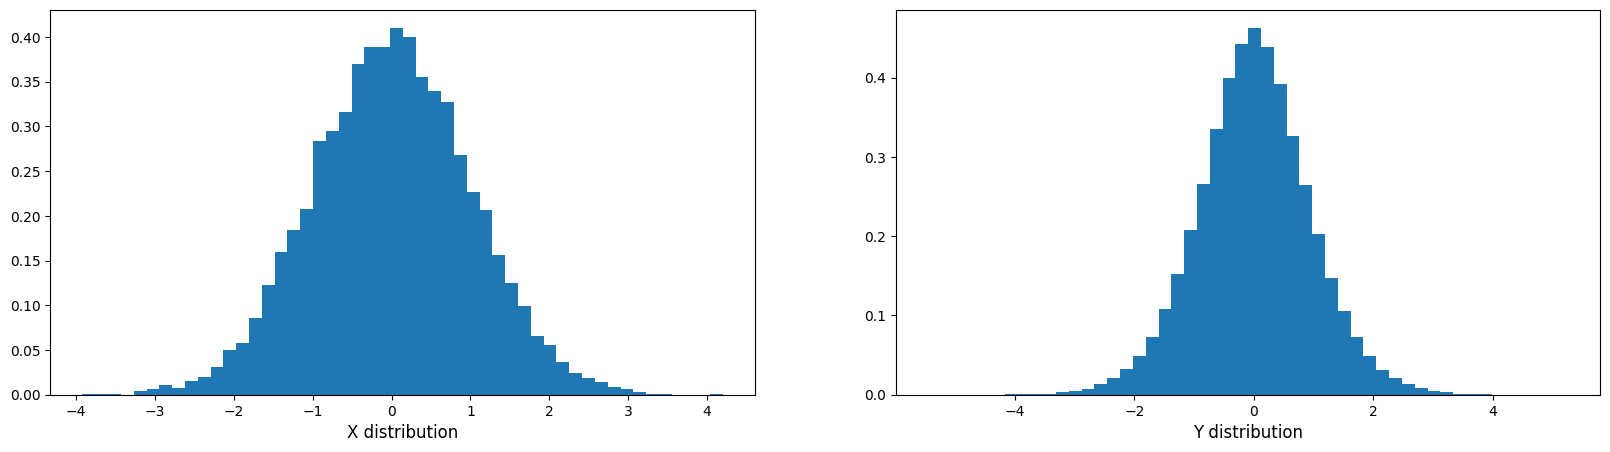

In [117]:
# showinng how multiplying weights by a constant at init can have an effect on the distribution of the output
# and we want output to generally be normal (0 mean, 1 std)
x = torch.randn(1000,10)
w = torch.randn(10,200) * .3
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.xlabel('X distribution', fontsize=12)
plt.hist(x.view(-1).tolist(),50,density=True);
plt.subplot(122)
plt.xlabel('Y distribution', fontsize=12)
plt.hist(y.view(-1).tolist(),50,density=True);

In [118]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # hidden layer pre-activation(want these to be roughly gaussian)
    # Linear layer
    hpreact = embcat @ W1 #+ b1(dont need bias since this is all getting normalized by subtracting mean anyway)
    # BatchNorm layer(usually used after layers that have multiplication, linear or convolutional)
    # --------------------------------------------------------------
    # calculate mean and std as training is going
    bnmeani = hpreact.mean(0, keepdims=True)
    bnstdi = hpreact.std(0, keepdims=True)
    # normalize h pre reaction to be roughly gaussian (batch normalization)
    # and then scale and shift by some values trained by the model so it is able to shift this distrubtion to its needs
    hpreact = bngain * (hpreact - bnmeani)/ bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + .001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + .001 * bnstdi
    # ----------------------------------------------------------------
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = .1 if i < 100000 else .01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


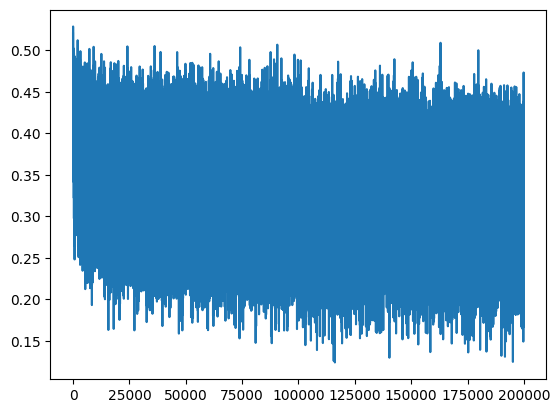

In [124]:
plt.plot(lossi)

In [120]:
# testing out why setting weights and biases randomly(which affect logits), is bad for initial loss, because at initialization
# every char should have equal probablity
#logits = torch.tensor([1.0, 1.0, 1.0, 1.0])
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([-0.8346, -5.3108,  4.5944, -0.1879]),
 tensor([4.3322e-03, 4.9282e-05, 9.8735e-01, 8.2711e-03]),
 tensor(0.0127))

In [121]:
# calibrate batch norm at the end of training, since now model is expecting batches, not 
# single inputs, which is what we would like to give in practice

with torch.no_grad():
    # pass training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #measure the mean/std over the entire training set
    bnmean = hpreact.mean(0,keepdim=True)
    bnstd = hpreact.std(0,keepdim=True)

bnstd.shape, bnmean.shape, hpreact.shape

#print(bnmean, bnstd)
#print(bnmean_running, bnstd_running)

(torch.Size([1, 200]), torch.Size([1, 200]), torch.Size([182625, 200]))

In [122]:
@torch.no_grad() # decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr), 
        'val': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdims=True))/hpreact.std(0, keepdims=True) + bnbias
    hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.066636800765991
val 2.105013132095337


In [123]:
# loss log

# original
train 2.12453
val 2.16819

# fix softmax confidently wrong(initial logits too varied, so softmax had more confidence in wrong answers, needing time to train and fix )
train 2.07
val 2.13

# fix tanh layer too saturated at init(hidden pre react values too far from zero so many tanh outputs were -1 or 1, which means gradient at that point is 0 and model never learns from those examples)
train 2.0355
val 2.1026

# add a batch normalization layer
train 2.0668
val 2.1048

SyntaxError: invalid syntax (2056548606.py, line 4)

In [125]:
# sample from the model
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1) # concatenate the vectors
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

briangmyazziyes.
bdulyah.
briyas.
brdrner.
sherkodrlithlyllsenleigh.
santhannchyziohmkrrnn.
shdumrishimnest.
jadestly.
prgbdulfuubdgghder.
jaquezmashburjahsis.
dashby.
sadya.
sus.
zakquslutel.
subristia.
sumprrdnn.
quloeonandphillsamreyxa.
hunton.
bdasirfalvinnwrllwildtalfr.
tandysestss.


In [ ]:
# "pytorch like" implementation

In [160]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        # divide by sqr(fan_in) to get better distrubtion at start
        self.weights = torch.randn((fan_in, fan_out), generator=g) / fan_in**.5
        self.bias = torch.zeros(fan_out) if bias else None
    def __call__(self,x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])

# class BatchNorm1d:
#     def __init__(self, dim, eps=1e-5, momentum=.1, affine=True):
#         self.momentum = momentum
#         self.eps = eps
#         self.dim = dim
#         self.training = True
#         # parameters(gain and bias to shift and scale the distibution after its normalized)
#         self.gamma = torch.ones(dim)
#         self.beta = torch.zeros(dim)
#         # buffers(trained with running 'momentum update')
#         self.running_mean = torch.zeros(dim)
#         self.running_var = torch.ones(dim)
        
#     def __call__(self, x):
#         if self.training:
#             # calc mean and variance from batch
#             xmean = x.mean(0, keepdim=True)
#             xvar = x.var(0,keepdim=True)
#         else:
#             xmean = self.running_mean
#             xvar = self.running_var
#         xhat = (x - xmean) / (torch.sqrt(xvar + self.eps))
#         self.out = self.gamma * xhat + self.beta
#         # update running mean and var
#         if self.training:
#             with torch.no_grad():
#                 self.running_mean = self.running_mean * (1 - self.momentum) + xmean * self.momentum
#                 self.running_var = self.running_var * .99 + xvar * self.momentum
#         return self.out
#     def parameters(self):
#         return [self.gamma, self.beta]


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [161]:
#set parameters for layers
# number of embeddings for chars
n_emb = 10
# number of neurons in hidden layers
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size,n_emb), generator=g)

layers = [
    Linear(n_emb*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False)
]

with torch.no_grad():
    # make last layer less confident at init, so model is less confidently wrong
    layers[-1].weights *= 0.1
    # for other layers, multiply by gain, so that values are not too big or small
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weights *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46970


In [165]:
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
    # get batch index
    ix = torch.randint(0,Xtr.shape[0], (32,))
    # get embeddings for x and y
    Xb, Yb = Xtr[ix], Ytr[ix]
    emb = C[Xb]

    #forward pass
    x = emb.view(emb.shape[0],-1)
    for layer in layers:
        #print(x)
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = .1 if i < 100000 else .01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item()}")
    lossi.append(loss.log10().item())
    #if i == 10000:
        #break
    

      0/  20000: 3.30218505859375
  10000/  20000: 2.263261318206787


1.8874889612197876


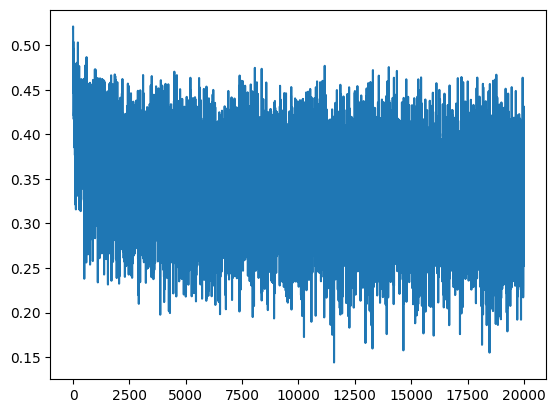

In [166]:
plt.plot(lossi)
print(loss.item())

layer 2 (Tanh): mean +0.03, std 0.67, saturated: 13.94%
layer 5 (Tanh): mean -0.02, std 0.71, saturated: 15.97%
layer 8 (Tanh): mean -0.01, std 0.74, saturated: 16.50%
layer 11 (Tanh): mean -0.03, std 0.78, saturated: 16.72%
layer 14 (Tanh): mean +0.02, std 0.64, saturated: 6.94%


Text(0.5, 1.0, 'activation distribution')

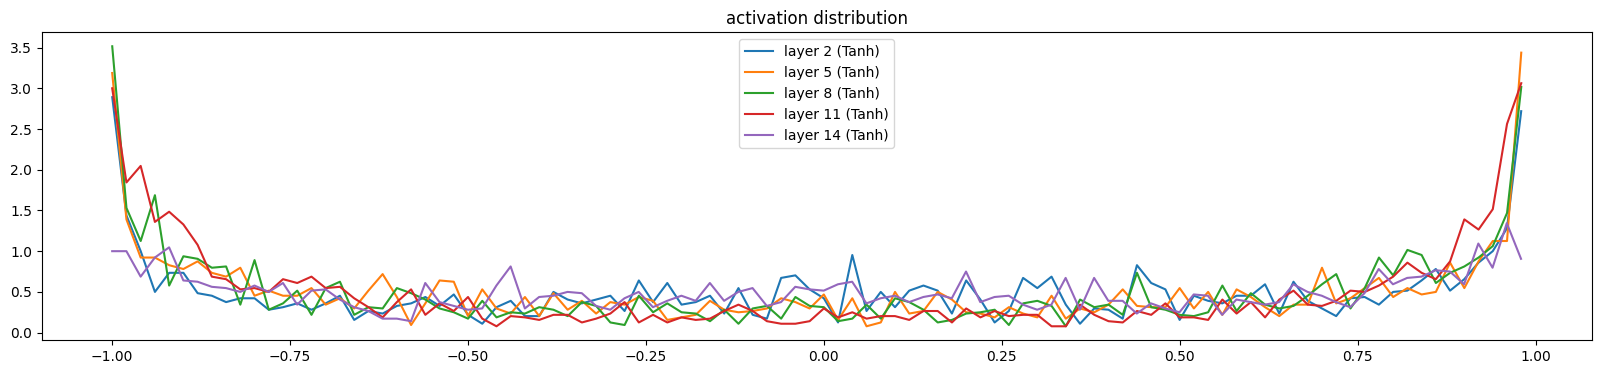

In [142]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

In [169]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

/var/folders/z5/81gv5lc94lg2dbfrv548wwr80000gn/T/ipykernel_32388/817535931.py:5: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  t = layer.out.grad


AttributeError: 'NoneType' object has no attribute 'mean'

<Figure size 2000x400 with 0 Axes>

weight   (27, 10) | mean +0.000000 | std 1.618175e-02 | grad:data ratio 1.470014e-02
weight  (30, 100) | mean +0.000164 | std 1.001239e-02 | grad:data ratio 2.429035e-02
weight (100, 100) | mean -0.000017 | std 6.148040e-03 | grad:data ratio 2.475593e-02
weight (100, 100) | mean +0.000037 | std 5.912614e-03 | grad:data ratio 2.404002e-02
weight (100, 100) | mean +0.000089 | std 5.716118e-03 | grad:data ratio 2.361072e-02
weight (100, 100) | mean +0.000026 | std 5.173575e-03 | grad:data ratio 2.135368e-02
weight  (100, 27) | mean -0.000000 | std 1.723051e-02 | grad:data ratio 7.207425e-02


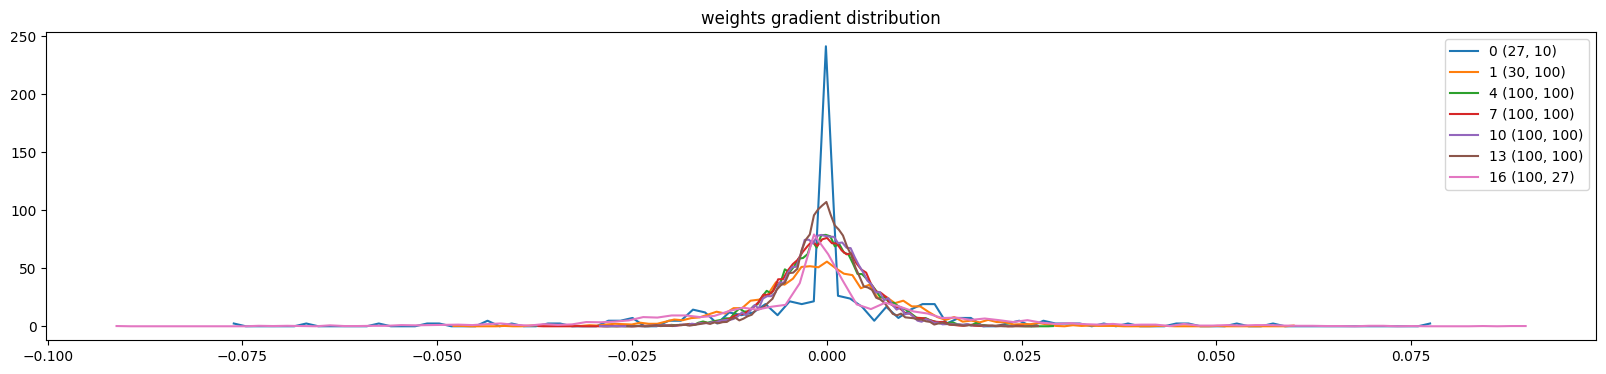

In [143]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  # linear layer ?
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [168]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
          # make sure layer isnt in training mode
        if isinstance(layer, BatchNorm1d):
            layer.training = False
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
     
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

mona.
kmyah.
seelend.
ryal.
remerstendra.
grace.
kamelin.
shi.
jen.
eden.
vana.
artelle.
malais.
nosherergiaghiel.
kindreelynn.
noeromi.
brence.
ruy.
julieks.
kaysh.
